## Visión por Computadora 1

## Trabajo Práctico N° 3

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Juan José Cardinali   | juanchijc@gmail.com       | a1809   |

### ENUNCIADO

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en *Material_TPs/TP3/images* a partir del template *Material_TPs/TP3/template*.

1. (4 puntos) Obtener una detección del logo en cada img sin falsos positivos.

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la img *coca_multi.png* con el mismo template del ítem1.

3. (2 puntos) Generalizar el algoritmo del item2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada img mostrando el nivel de confianza de la detección.

### RESOLUCIÓN

#### LIBRERÍAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import pandas as pd

#### DETECCIÓN DEL LOGO

In [2]:
# Definimos la lista de archivos a leer

def get_files(folderpath, extensions, excludes):
    # Filtra solo los archivos que tengan las extensiones deseadas y no estén en la lista de exclusiones
    files_list = []
    for file_name in os.listdir(folderpath):
        if any(file_name.endswith(ext) for ext in extensions) and file_name not in excludes:
            files_list.append(file_name)
    return files_list

folderpath = './imagenes/'  # Asegúrate de que esta ruta sea correcta

# Obtener imágenes de la carpeta
imgs_to_read = get_files(folderpath, ['.png', '.jpg'], ['coca_multi.png'])
imgs_to_read

['COCA-COLA-LOGO.jpg',
 'coca_logo_1.png',
 'coca_logo_2.png',
 'coca_retro_1.png',
 'coca_retro_2.png',
 'logo_1.png']

In [3]:
# Cantidad de imagenes a leer
n_img_to_read = len(imgs_to_read)
n_img_to_read

6

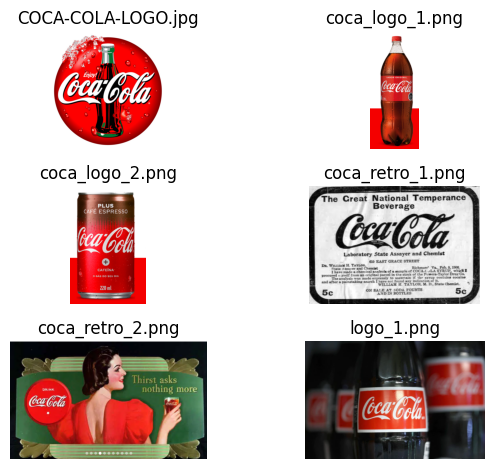

In [4]:
# Visualizamos las imágenes

# Grilla de ploteo
cols = 2
rows = (n_img_to_read + cols - 1) // cols

plt.figure()

data=[]
for idx, img_name in enumerate(imgs_to_read):

    img_path = folderpath + img_name
    img = cv.imread(img_path)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    shape = img.shape
    data.append({
            'Nombre': img_name,
            'Alto': shape[0],
            'Ancho': shape[1],
            'Canales': shape[2] if len(shape) == 3 else 1
        })
    
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(imgRGB)
    plt.title(img_name)
    plt.axis('off')
    
plt.tight_layout() 
plt.show()

df_img_shapes = pd.DataFrame(data)

Ancho del tamplate: 400
Alto del template: 175


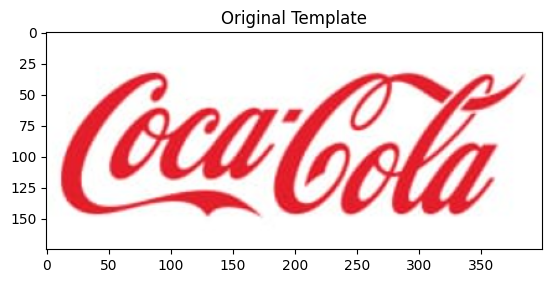

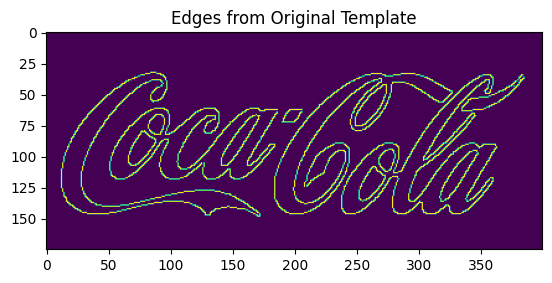

In [5]:
# Leemos el template
template = cv.imread('./templates/pattern.png')
templateRGB = cv.cvtColor(template, cv.COLOR_BGR2RGB)
templateGRAY = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
templateEDGES = cv.Canny(templateGRAY, 50, 200)

# Obtener dimensiones del template
w, h = template.shape[1], template.shape[0]
print(f'Ancho del tamplate: {w}')
print(f'Alto del template: {h}')

# Display template
plt.figure()
plt.imshow(templateRGB)
plt.title('Original Template')
plt.show()

plt.figure()
plt.imshow(templateEDGES)
plt.title('Edges from Original Template')
plt.show()

In [6]:
# Verificamos el tamaño del template respecto
df_img_shapes['TemplateEscalaOk'] = df_img_shapes.apply(
    lambda row: True if ((row['Alto'] > h) and (row['Ancho'] > w)) else False,
    axis=1
)
df_img_shapes

,Nombre,Alto,Ancho,Canales,TemplateEscalaOk
0,COCA-COLA-LOGO.jpg,1389,1389,3,True
1,coca_logo_1.png,500,207,3,False
2,coca_logo_2.png,363,233,3,False
3,coca_retro_1.png,493,715,3,True
4,coca_retro_2.png,429,715,3,True
5,logo_1.png,450,687,3,True


**OBSERVACIONES:**

- Las imágenes 'coca_logo_1.png' y 'coca_logo_2.png' son más chicas que el template. O debemos achicar el template, o agrandar la imagen, o ambas en un punto intermedio.

Definimos una función general para analizar cada imagen, donde adoptamos un esquema del tipo "Multi-scale template matching", en donde comparamos el template contra múltiples escalas de la imagen objetivo.

Aplicamos el siguiente procedimiento general:

1) Convertimos la imagen objetivo y el template a escalas de grises y luego aplicamos el algoritmo de Canny para detección de bordes.

2) Definimos las multiples escalas de la imagen objetivo, definiendo un limite inferior (*scale_bot*) y la cantidad de niveles (*levels*). Si es necesario, escalamos hacia arriba la imagen objetivo para que el template quepa en ella.

3) Hacemos un loop sobre las multiples escalas. La imagen de input se decrece progresivamente hasta una fracción *scale_bot*.

4) Aplicamos *Template matching* para cada escala y nos quedamos con el mejor resultado (el máximo o mínimo, según la métrica).


In [7]:
def multiscale_template_matching(img_target, template, meth, scale_bot = 0.20, levels=20):
    """ Realiza la coincidencia de patrones entre una imagen y un template, utilizando pirámides gaussianas. """
    
    # Convertir target to rgb and gray
    img_targetRGB = cv.cvtColor(img_target, cv.COLOR_BGR2RGB)
    img_targetGRAY = cv.cvtColor(img_target, cv.COLOR_BGR2GRAY)

    # Convertir template to gray and edge
    templateGRAY = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    templateEDGES = cv.Canny(templateGRAY, 50, 200)

    # Obtener dimensiones del template
    w_temp, h_temp = templateGRAY.shape[1], templateGRAY.shape[0]

    # Obtener dimensiones de la imagen
    w_img, h_img = img_targetGRAY.shape[1], img_targetGRAY.shape[0] 

    # En caso de que el template sea mayor a la imagen en alguna dimensión, re-escalamos para arriba la imagen objetivo.
    scale_top = max([1, w_temp/w_img, h_temp/h_img])

    # Inicializar variables para seguimiento
    best_value = -float('inf')
    if eval(meth) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        best_value *= -1 

    best_location = None
    best_res = None

	# loop over the scales of the image
    for scale in np.linspace(scale_bot, scale_top, levels)[::-1]:
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing
        resized = cv.resize(img_targetGRAY, (int(w_img * scale), int(h_img * scale)))
        r = w_img / float(resized.shape[1])
		
        if resized.shape[1] < w_temp or resized.shape[0] < h_temp:
            break
	
		# detect edges in the resized, grayscale image and apply template
		# matching to find the template in the image
        edged = cv.Canny(resized, 50, 200)
        method = eval(meth)
        res = cv.matchTemplate(edged, templateEDGES, method)

		# Encontramos los valores mínimos y máximos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
        if eval(meth) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            current_value = min_val
            current_loc = min_loc
        else:
            current_value = max_val
            current_loc = max_loc

        # Comprueba si la coincidencia es la mejor encontrada
        if eval(meth) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            if current_value < best_value:
                best_value = current_value
                best_location = (current_loc[0] * r, current_loc[1] * r)
                best_res = res
                best_w = w_temp * r
                best_h = h_temp * r
        else:
            if current_value > best_value:
                best_value = current_value
                best_location = (current_loc[0] * r, current_loc[1] * r)
                best_res = res
                best_w = w_temp * r
                best_h = h_temp * r

    # Asegurarse de que se encontró una coincidencia antes de continuar
    if best_location is None:
        print("No se encontraron coincidencias.")
        return img_target  # Retorna la imagen original si no se encontró nada

    # Marcar la mejor coincidencia encontrada en la imagen de la última pirámide
    top_left = (int(best_location[0]), int(best_location[1]))  # Convertir a enteros
    bottom_right = (int(top_left[0] + best_w), int(top_left[1] + best_h))  # Convertir a enteros
    cv.rectangle(img_targetRGB, top_left, bottom_right,(0, 0, 255), 2)

    # Graficamos el procesamiento y la salida
    plt.figure(figsize=(10, 5))
    
    # Resultado de coincidencia
    plt.subplot(121)
    plt.imshow(best_res)
    plt.title('Matching Result')
    plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(122)
    plt.imshow(img_targetRGB)
    plt.title('Detected Point')
    plt.xticks([]), plt.yticks([])
    
    plt.suptitle(meth)
    plt.show()	


Aplicamos el algoritmo:

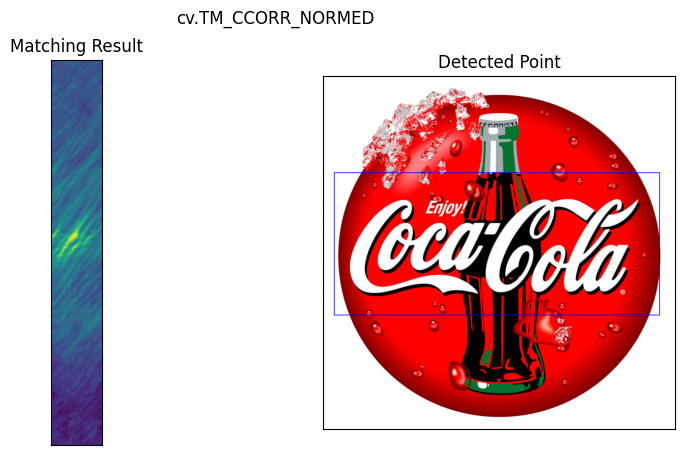

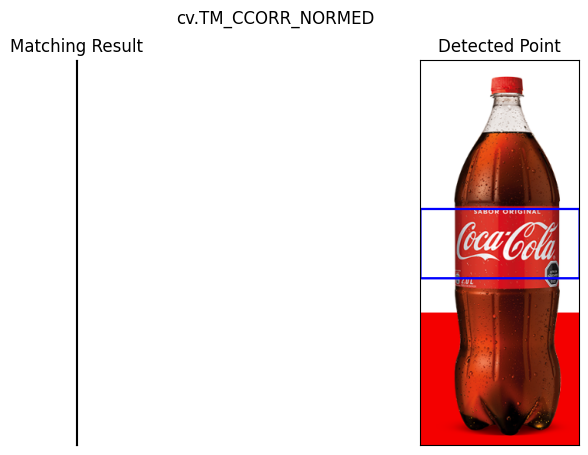

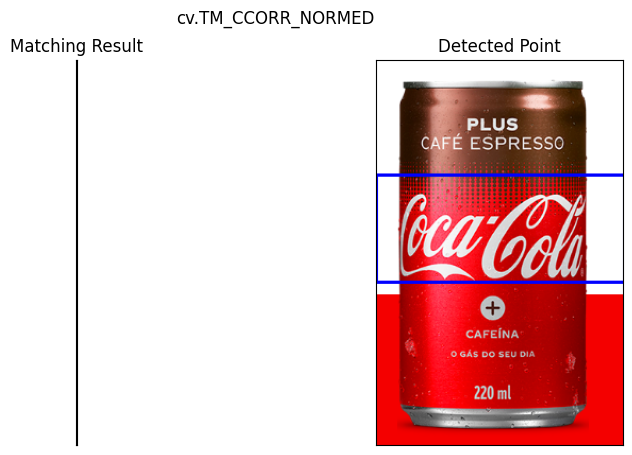

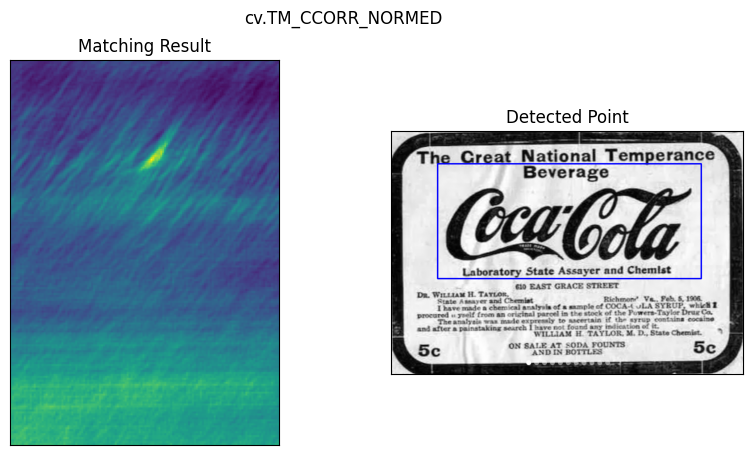

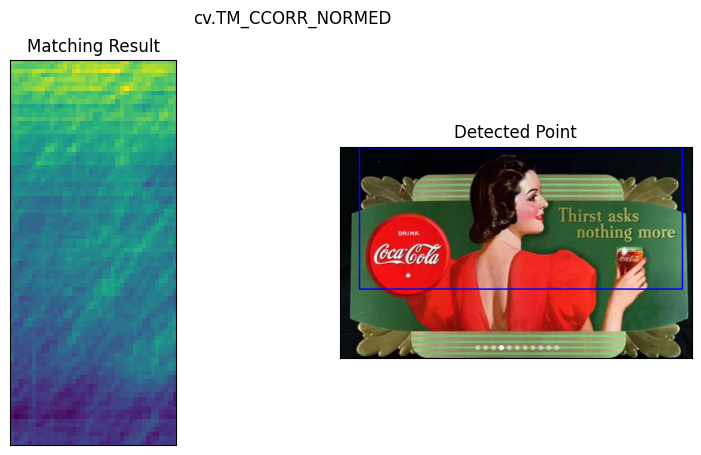

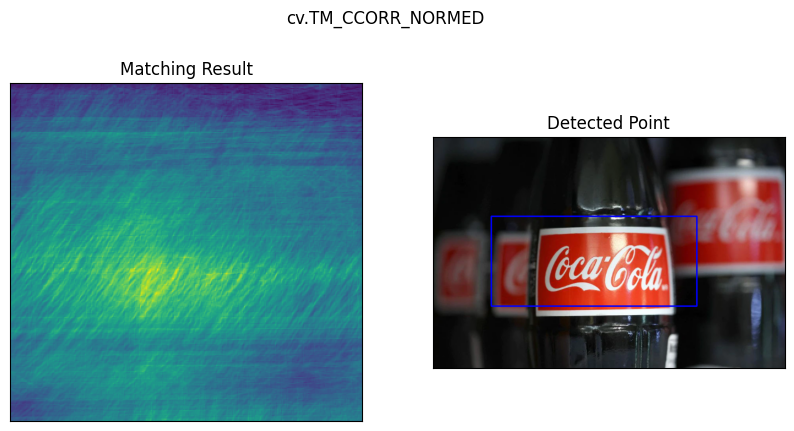

In [8]:
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF',                  # Coeficiente de correlación (máximo)
            'cv.TM_CCOEFF_NORMED',          # Coeficiente de correlación normalizado (máximo) 
            'cv.TM_CCORR',                  # Correlación cruzada (máximo)
            'cv.TM_CCORR_NORMED',           # Correlación cruzada normalizada (máximo) 
            'cv.TM_SQDIFF',                 # Suma de diferencias al cuadrado  (mínimo)
            'cv.TM_SQDIFF_NORMED']          # Suma de diferencias al cuadrado normalizado (mínimo)

# Leemos el template
template = cv.imread('./templates/pattern.png')

for img_name in imgs_to_read:

    img_path = folderpath + img_name
    img_target = cv.imread(img_path)
    
    multiscale_template_matching(img_target, template, methods[3], levels=100)

**OBSERVACIONES:**

- El esquema de detección definido nos permitió conseguir buenos resultados en todos los casos, con excepción  imagen "coca_retro_2.png", en la cual el algoritmo de detección no detectar correctamente el logo.

### DETECCIÓN MULTIPLE

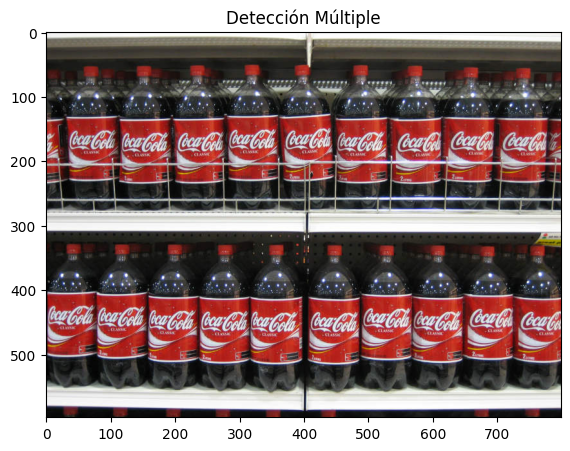

In [9]:
# Cargamos la imagen objetivo
img_target_multi = cv.imread('./Imagenes/coca_multi.png')
img_target_multiRGB = cv.cvtColor(img_target_multi, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(img_target_multiRGB)
plt.title('Detección Múltiple')
plt.show()

**OBSERVACIONES:**

- Vemos que el logo de Coca-Cola tiene un ancho aproximado de 80 pixeles. Recordando que el template tiene un ancho de 400, lo escalamos por 1/5.

Definimos una función para enmascarar 

In [10]:
def CrearMascara_etiquetas(img):
    # Hacer una copia para no modificar la imagen original
    img_copy = img.copy()

    # 2. Conversión a HSV para segmentación por color
    hsv = cv.cvtColor(img_copy, cv.COLOR_BGR2HSV)

    # 3. Definir rangos para el color rojo
    # Ajusta estos rangos (más saturación, diferente iluminación, etc.)
    lower_red_1 = np.array([0, 70, 50])
    upper_red_1 = np.array([10, 255, 255])
    lower_red_2 = np.array([170, 70, 50])
    upper_red_2 = np.array([180, 255, 255])

    # Crear dos máscaras y combinarlas
    mask1 = cv.inRange(hsv, lower_red_1, upper_red_1)
    mask2 = cv.inRange(hsv, lower_red_2, upper_red_2)
    mask_red = cv.bitwise_or(mask1, mask2)

    # 4. Operaciones morfológicas para suavizar la máscara
    # Un kernel grande ayuda a “cerrar” huecos en la etiqueta
    kernel_close = np.ones((15, 15), np.uint8)
    mask_closed = cv.morphologyEx(mask_red, cv.MORPH_CLOSE, kernel_close)

    # 5. Eliminamos ruidos pequeños (por ejemplo, tapas y pequeñas manchas)
    #    5.1. Buscamos contornos en la máscara 'mask_closed'
    contours, _ = cv.findContours(mask_closed.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    #    5.2. Creamos una nueva máscara para dibujar únicamente los contornos grandes (etiquetas)
    mask_filtered = np.zeros_like(mask_closed)

    # Definir un área mínima para descartar tapas (objetos pequeños)
    min_area = 2000  # Ajusta este valor según el tamaño de tus imágenes

    for cnt in contours:
        area = cv.contourArea(cnt)
        if area > min_area:
            # Rellenamos en la máscara los contornos grandes
            cv.drawContours(mask_filtered, [cnt], -1, 255, thickness=-1)

    # 6. Volvemos a cerrar huecos dentro de las etiquetas con un cierre morfológico adicional
    kernel_close2 = np.ones((10, 10), np.uint8)
    mask_final = cv.morphologyEx(mask_filtered, cv.MORPH_CLOSE, kernel_close2)

    # 7. Aplicamos la máscara final a la copia de la imagen para mostrar SOLO las etiquetas
    result = cv.bitwise_and(img_copy, img_copy, mask=mask_final)

    # 8. Retornamos el resultado (la imagen con solo las etiquetas visibles)
    return result

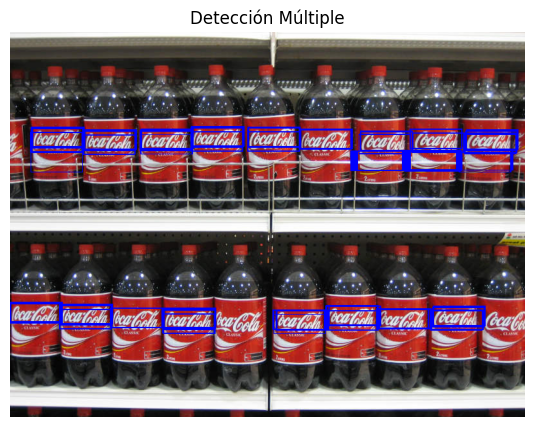

In [27]:
def multiple_detection(img_target, template, threshold=0.3, scale_temp_factor = None):

    # Convertir la imagen objetivo a RGB y escala de grises
    img_targetRGB = cv.cvtColor(img_target, cv.COLOR_BGR2RGB)
    img_targetGRAY = cv.cvtColor(img_target, cv.COLOR_BGR2GRAY)

    # Convertir la plantilla a escala de grises
    templateGRAY = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    musk_etiquetas=CrearMascara_etiquetas(img_target) #creo una mascara para evitar falsos positivos
    musk_etiquetasGRAY = cv.cvtColor(musk_etiquetas, cv.COLOR_BGR2GRAY)

    w, h = templateGRAY.shape[::-1]

    if scale_temp_factor is not None:
        templateGRAY = cv.resize(templateGRAY, (int(w * scale_temp_factor), int(h * scale_temp_factor)))
        w, h = templateGRAY.shape[::-1]
    
    res = cv.matchTemplate(musk_etiquetasGRAY, templateGRAY, cv.TM_CCOEFF_NORMED)

    loc = np.where( res >= threshold)
    for pt in zip(*loc[::-1]):
        cv.rectangle(img_targetRGB, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_targetRGB)
    plt.title('Detección Múltiple')
    plt.axis('off')  # Ocultar los ejes
    plt.show()

# Ejecutar la detección múltiple
template2 = cv.imread('./templates/temp_coca_multi.png')        # Generamos un template para este caso particular
multiple_detection(img_target_multi, template2, threshold=0.275) 